# A Whirlwind Tour of Decision Trees

The decision tree[<a href="https://en.wikipedia.org/wiki/Decision_tree_learning">1</a>][<a href="http://scikit-learn.org/stable/modules/tree.html">2</a>] is a machine learning model that encode a tree like structure where inner nodes correspond to questions asked of the sample, edges correspond to answers, and leaf nodes correspond to the label predicted for a sample with a specific path through thr tree. They can be applied to both classification problems[<a href="https://en.wikipedia.org/wiki/Statistical_classification">1</a>][<a href="http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier">2</a>][<a href="https://www.datarobot.com/blog/classification-with-scikit-learn/">3</a>], where one wishes to assign one of a fixed set of labels to a sample, or regression problems[<a href="https://en.wikipedia.org/wiki/Regression_analysis">1</a>][<a href="http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor">2</a>], where one wishes to predict a continuous value. Frequently the decision tree is not used alone, but is used as an ensemble[<a href="https://en.wikipedia.org/wiki/Ensemble_learning">1</a>][<a href="http://scikit-learn.org/stable/modules/ensemble.html">2</a>] either in the form of a random forest[<a href="https://en.wikipedia.org/wiki/Random_forest">1</a>][<a href="http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html">2</a>][<a href="http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html">3</a>] or in the context of gradient boosting[<a href="https://en.wikipedia.org/wiki/Gradient_boosting">1</a>][<a href="http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html">2</a>][<a href="http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html">3</a>][<a href="http://xgboost.readthedocs.io/en/latest/model.html">4</a>] in which the predictions from many trees are aggregated to form the final prediction.

Tree based models starkly contrast with other common types of models, specifically <b>probabilistic models</b>[<a href="https://en.wikipedia.org/wiki/Generative_model">1</a>] such as naive Bayes[<a href="https://en.wikipedia.org/wiki/Naive_Bayes_classifier">1</a>][<a href="http://scikit-learn.org/stable/modules/naive_bayes.html">2</a>][<a href="https://github.com/jmschrei/pomegranate/blob/master/tutorials/Tutorial_5_Bayes_Classifiers.ipynb">3</a>] and mixture models[<a href="https://en.wikipedia.org/wiki/Mixture_model">1</a>][<a href="http://scikit-learn.org/stable/modules/mixture.html">2</a>][<a href="https://github.com/jmschrei/pomegranate/blob/master/tutorials/Tutorial_2_General_Mixture_Models.ipynb">3</a>] that explicitly assign probability distributions to the underlying phenomena and treat observations as samples from these distributions, or <b>compositional differentiable functions</b>, more frequently called <b>neural networks</b>[<a href="https://en.wikipedia.org/wiki/Artificial_neural_network">1</a>][<a href="http://scikit-learn.org/stable/modules/neural_networks_supervised.html">2</a>][<a href="http://scikit-learn.org/stable/modules/neural_networks_unsupervised.html">3</a>] that range in complexity from the simple logistic regression to very deep networks such as GoogLeNet[<a href="https://research.google.com/pubs/pub43022.html">1</a>] and ResNets[<a href="https://arxiv.org/pdf/1512.03385.pdf">1</a>][<a href="http://icml.cc/2016/tutorials/icml2016_tutorial_deep_residual_networks_kaiminghe.pdf">2</a>]. While there are a great many views on the differences between probabilistic models and neural networks, the most common is that probabilistic models fall under the umbrella of <b>generative models</b> that capture the underlying distribution of the data whereas neural networks typically fall under the umbrella of <b>discriminative models</b>[<a href="https://en.wikipedia.org/wiki/Discriminative_model">1</a>][<a href="http://www.cedar.buffalo.edu/~srihari/CSE574/Discriminative-Generative.pdf">2</a>][<a href="https://stackoverflow.com/questions/879432/what-is-the-difference-between-a-generative-and-discriminative-algorithm">3</a>]. Decision trees are also discriminative models as their value comes in making accurate predictions and not in their ability to produce samples faithful to the original data distribution. However, they are distinct from neural networks in that neural networks typically use some form of gradient descent[<a href="https://en.wikipedia.org/wiki/Gradient_descent">1</a>][<a href="http://scikit-learn.org/stable/modules/sgd.html">2</a>] for training whereas decision trees do not.

In this tutorial we will explore the concept of a decision tree. We will start with comparing the predictions of a decision tree to other types of models. We will then go into detail to understand the components of how to build a decision tree, and end up with a fully working decision tree model. Then we will go into random forests and parallelization.

In [4]:
%pylab inline
import numpy as np
np.random.seed(0)
import seaborn; seaborn.set_style('whitegrid')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 16
matplotlib.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14


Populating the interactive namespace from numpy and matplotlib


# What does a decision tree's predictions look like?

Before exploring any of the theoretical or implementation details of a decision tree, let's treat it as a black box and simply look at the type of predictions that it makes and decision boundary[<a href="https://en.wikipedia.org/wiki/Decision_boundary">1</a>][<a href="http://scikit-learn.org/stable/auto_examples/tree/plot_iris.html">2</a>] that it learns. The decision boundary is the border between the predictions of one class with that of another class. Typically these are either straight lines for linear models, like a logistic regression[<a href="https://en.wikipedia.org/wiki/Logistic_regression">1</a>][<a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html">2</a>][<a href="http://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_l1_l2_sparsity.html">3</a>], or curves for more complex models such as a naive Bayes classifier.

Let's load up some binary blob data and take a look at it.

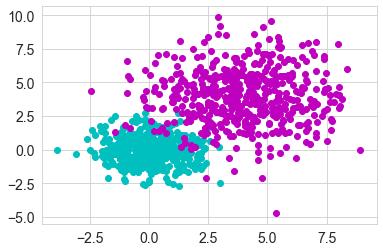

In [411]:
x1 = np.random.randn(500,2)
x2 = 2*np.random.randn(500,2)+4
X = np.concatenate((x1,x2))
y = np.concatenate((np.zeros(500),np.ones(500)))
plt.scatter(X[y==0,0],X[y==0,1],color = 'c')
plt.scatter(X[y==1,0],X[y==1,1],color = 'm');

This is some fairly simplistic data, with the cyan samples representing one class and the magenta samples representing another class. The magenta blob appears to have a higher variance than the cyan blob. The interesting aspect will be how the overlap between the two classes is handled. As a comparison, let's see how a logistic regression, a naive Bayes classifier, and a multi-layer perceptron neural network compare when making these predictions.

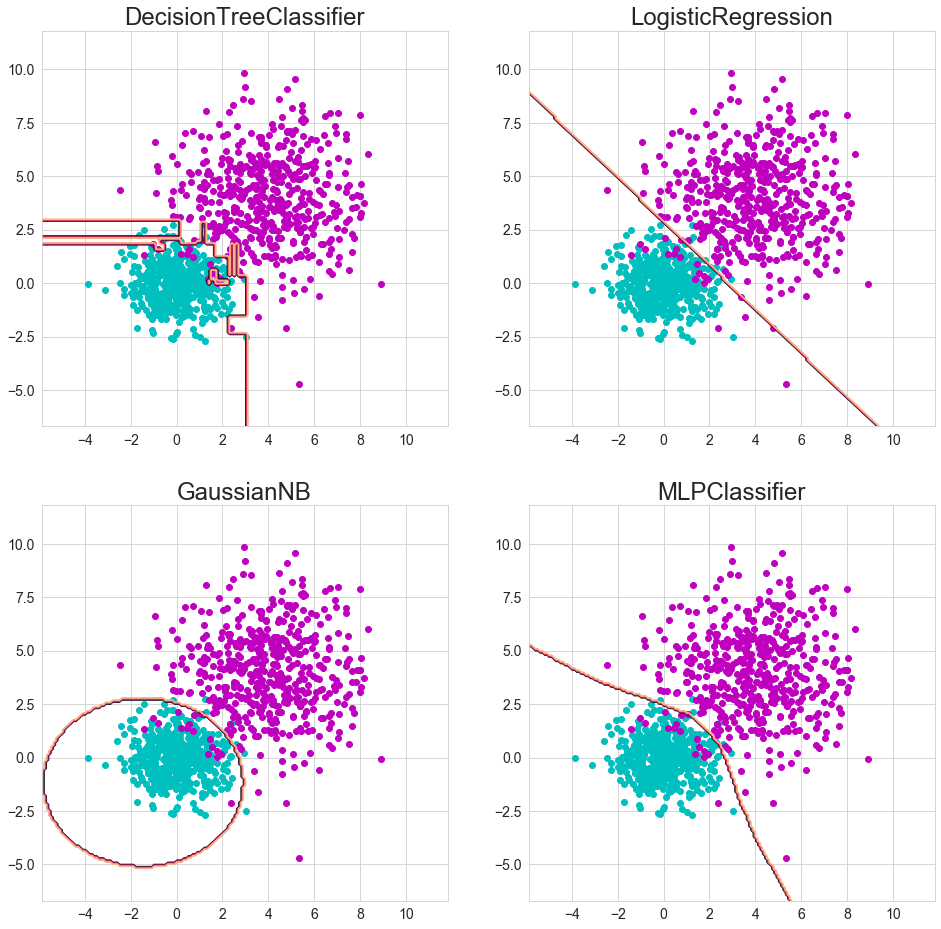

In [413]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

def plot_contours(X,y,*classifiers):
    x_min,x_max = X[:,0].min() - 2, X[:,1].max() + 2
    y_min,y_max = X[:,1].min() - 2, X[:,1].max() + 2
    
    #nxn matrices where each row is a sequence from x_min to x_max
    xx,yy = np.meshgrid(np.arange(x_min,x_max,0.1),
                       np.arange(y_min,y_max,0.1))
    colors = ['c', 'm', 'g', 'r', 'b', 'y', '#FF6600']
    n = len(classifiers)
    for i,clf in enumerate(classifiers):
        clf.fit(X,y)
        #creates a dataseet of combinations of the two sequences (xx and yy). Thus, for each x and y
        #in our sequence we will get a prediction. Then we put it back into matrix form.
        Z = clf.predict(np.c_[xx.ravel(),yy.ravel()]).reshape(xx.shape)
        plt.subplot((n-1)/2+1,2,i+1)
        plt.title(clf.__class__.__name__,fontsize = 24)
        plt.contour(xx,yy,Z)
        for j in np.unique(y).astype('int'):
            plt.scatter(X[y==j,0],X[y==j,1],color = colors[j])

clf1 = DecisionTreeClassifier()
clf2 = LogisticRegression()
clf3 = GaussianNB()
clf4 = MLPClassifier()

plt.figure(figsize = (16,16))
plot_contours(X,y,clf1,clf2,clf3,clf4)

There is an immediate distinction between the decision tree model and the other models. The naive Bayes model produces a nice curve separating the two classes, the linear SVM produce a line that cuts the space into two sections, and the MLP produces a more complicated boundary but still roughly a line that cuts the space into two sections. However, the decision tree boundary is completely different than the other two. The first thing to notice is that the boundary is made up of many lines that occur only along a single axis. This will become clear later. The second is that it appears to have much more structure than the other models. This suggests a greater potential to overfit to data, as it will carve out small sections of magenta in a sea of cyan and claim that all points that lie there must be magenta.

Next, there are many tree based models that one might consider. We looked at an individual decision tree, but one can also use an ensemble of decision trees called a random forest, or grow a sequence of trees via gradient boosting. Let's take a look at the decision boundaries produced by these other tree-based techniques.

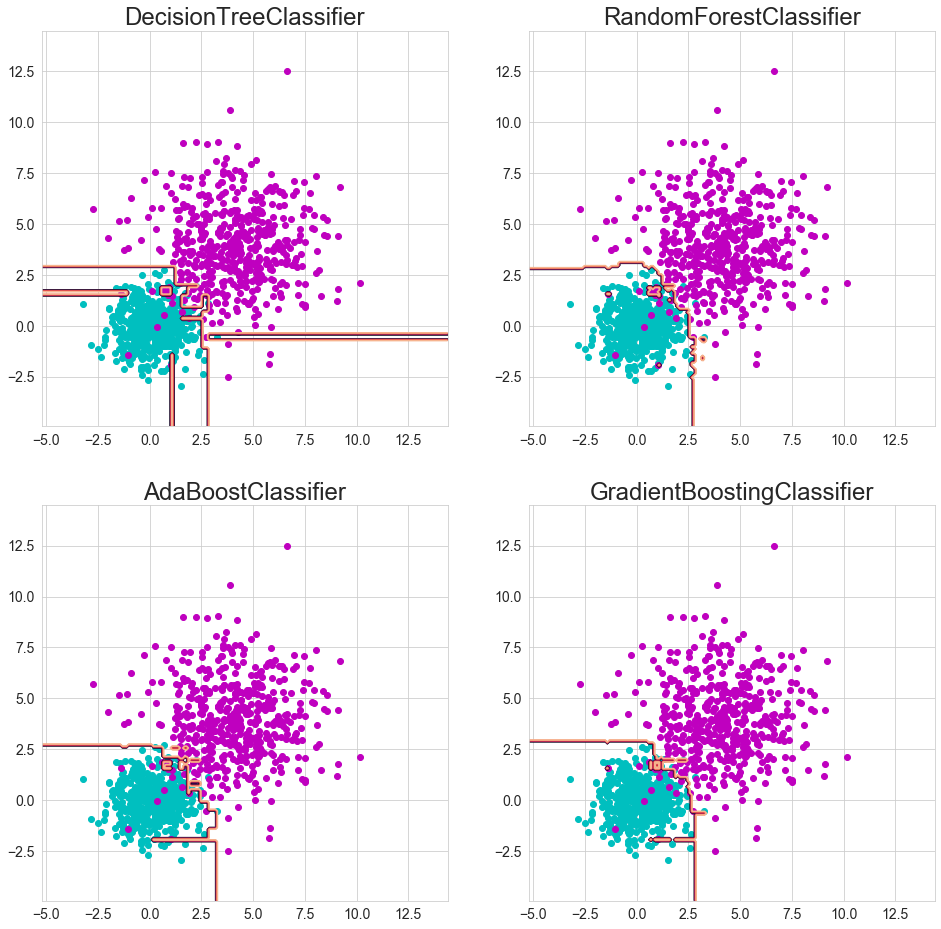

In [105]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

clf1 = DecisionTreeClassifier()
clf2 = RandomForestClassifier(n_estimators=100)
clf3 = AdaBoostClassifier(n_estimators=100)
clf4 = GradientBoostingClassifier(n_estimators=100)

plt.figure(figsize=(16, 16))
plot_contours(X, y, clf1, clf2, clf3, clf4)
plt.show()

They all appear to have the same trait that they produce decision boundaries where sections fall under a single dimension. When we delve into how decision trees work later it would quickly become apparent why this is the case. An interesting thing to note is that all of the methods that build on decision trees seem to produce smoother, more generalizable decision boundaries. Specifically, in the decision boundary produced by the Random Forest classifier, there aren't tiny sections carved out for a small number of points like in the original decision tree model. All of these features will be explained soon!

# So What is a Decision Tree Anyway?

Decision trees are rule-based models that have a tree-like structure, where each inner node corresponds to a rule, i.e. a threshold on a single feature of the dataset, and each leaf node corresponds to a prediction. Each sample flows down the tree, selecting at each node whether to go to the left or right child based on the embedded rule, and the model predicts the value in the leaf node that the sample lands in. This is why decision boundaries for decision trees are made up of lines falling on an axis-- because thresholds are set on individual features at a time.

What does this look like? Let's turn to the iris dataset to find out. The iris dataset is a commonly used benchmark in ML tasks because is small, multiclass, with some of these classes being easy to separate and others more difficult. A good classifier should be able to distinguish between all of the classes well.

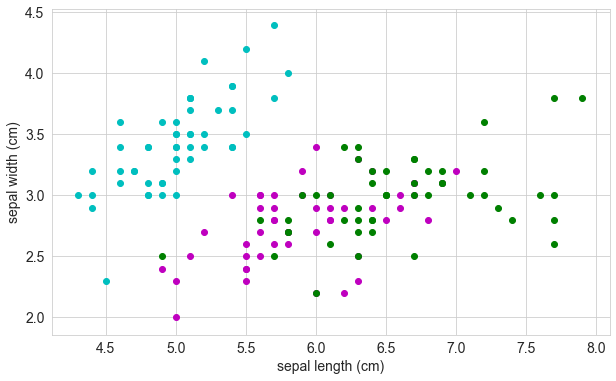

In [106]:
from sklearn.datasets import load_iris

data = load_iris()
X, y = data['data'], data['target']

plt.figure(figsize=(10, 6))
plt.scatter(X[y==0, 0], X[y==0, 1], color='c')
plt.scatter(X[y==1, 0], X[y==1, 1], color='m')
plt.scatter(X[y==2, 0], X[y==2, 1], color='g')
plt.xlabel(data['feature_names'][0])
plt.ylabel(data['feature_names'][1])
plt.show()

We are ony plotting two of the four features here, so this isn't the full picture of the dataset, but it does highlight some of the important characteristics of the dataset. For example, the cyan samples seem to be completely separated from the other two, whereas the magenta and green samples are intertwined. A classifier will likely do quite well at identifying the cyan class, but probably worse at identifying the other two.

Let's now learn a decision tree over the data and visualize the tree, to get an idea for what decision trees look like internally.

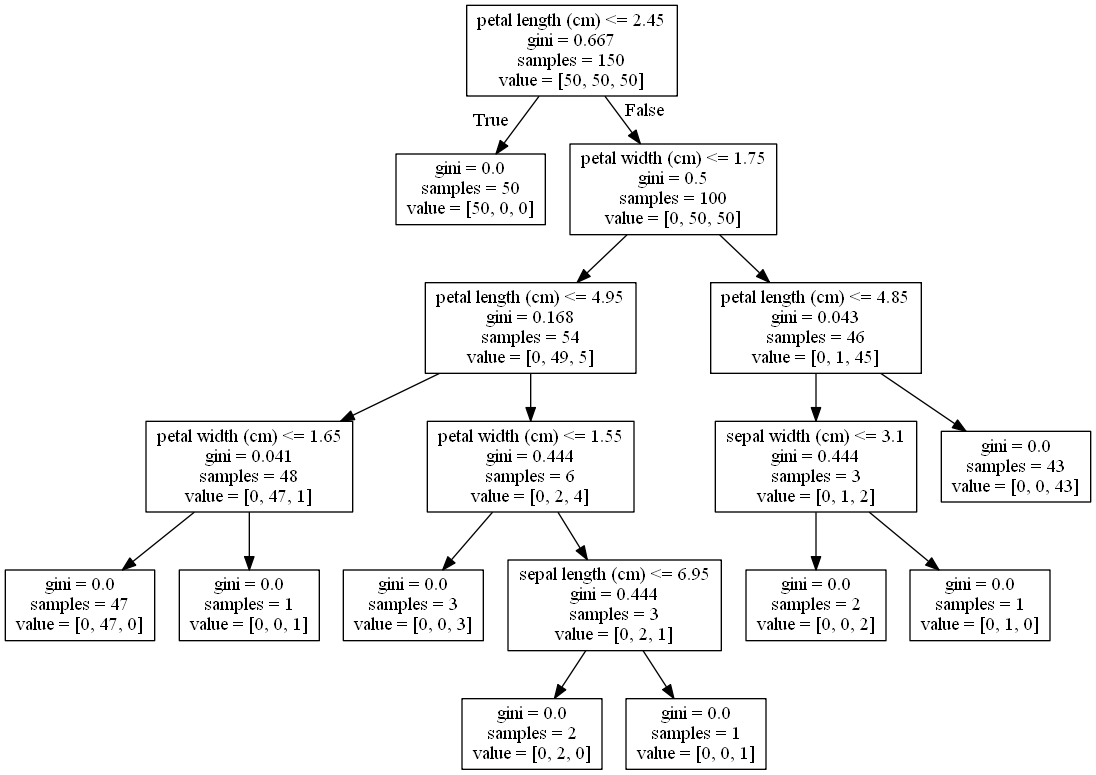

In [111]:
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

clf = DecisionTreeClassifier().fit(X, y)
tree = export_graphviz(clf, None, feature_names=data['feature_names'])
tree = pydotplus.graph_from_dot_data(tree)
Image(tree.create_png())

Each one of the boxes corresponds to a node (leaf or inner) of the tree. The first line of an inner node is the threshold that node sets on the data. The second is the measurement of some criterion on all the training samples that reached that node. In this case we used Gini impurity[<a href="https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity">1</a>] (by default) and so this shows the Gini impurity at each node, with 0.0 meaning purely one class. The next line shows the number of training samples that got to that node. Lastly, the values line shows the composition of those samples amongst the various classes that they could be. For example, if we look at the children of the root node, the left child, that happens to also be a leaf, has 50 samples in it that all correspond to the first class. Correspondingly, its gini impurity is 0, because only samples from one class have made it. Inspecting the distribution in `values`, it would appear that all 50 samples that make up class 0 are present at that node, suggesting that petal width is a great distinguisher for this specific type of iris.

When one wishes to make a prediction, they repeatedly apply the thresholds found in the nodes until the sample makes its way to a leaf node. Let's take the case of the sample with petal width = 0.9, petal length = 4.6, and sepal length = 1.8. We start off on the root node. Since petal width > 0.8, we then proceed to the right child (left child always means true, right child always means false). Then, we check petal width again and see that it is indeed <= 1.75, so we proceed to the left child. Then, we consider petal length, and see that it is <= 4.95 and so proceed to the left child again. Lastly, we see that the width comes up as a feature again and we are indeed <= 1.65, and so proceed to the left child. Since that child is a leaf, we now issue a prediction for class 1. 

The process outlined above results in a 'decision path'. A decision path is the path through the tree that a sample takes, identifying the nodes along the way that mattered. This is a very beneficial property because it explicitly tells you what features were used for a classification, helpful in settings where you need to explain to managers, customers, or the government, why exactly the model made a certain prediction.

Let's recreate what we just did programmatically. First we'll need to look up the feature names to make sure we put the right values in.

In [108]:
print(data['feature_names'])

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


Interestingly there are four variabbles, but only three of them show up in the tree. Presumably one of them is not particularly useful. Next, we use the `decision_path` method to get the path.

In [112]:
path = clf.decision_path([[1.8, 0.9, 4.6, 0.9]])
print(path)

  (0, 0)	1
  (0, 2)	1
  (0, 3)	1
  (0, 4)	1
  (0, 5)	1


`decision_path` returns a csr sparse matrix to us. A sparse matrix is an efficient way of storing an array that has many 0's in it by not actually storing the 0's at all. The first tuple in the output corresponds to the position in a matrix that a non-zero value exists at, and the number is the value that exists at that position. For example, at index (0, 0) in the matrix (the top left corner) the value 1 exists. You'll notice that all of the values are 1 for this return. This is because the decision path is returned as a bit array where a value of 1 means that the sample visited that node during the prediction phase. The ordering of a tree in the array is depth-first, meaning that active bits (1s) proceed down the tree as one scans to the right of the tree. Ultimately, the first number in the tuple corresponds to the sample one is calculating a decision path for, and the second number corresponds to the node index that is active. In the example above, this means that the same passed through nodes 0, 2, 3, 4, and 5 according to a depth first search through the tree.

Getting the indices according to a depth first search isn't terribly informative. We should write a function that will take these indices and return more meaningful information, such as the features that were seen and the thresholds for those features.

First, let's get the features:

In [9]:
print clf.tree_.feature[path.toarray().astype('bool')[0]]

[ 3  3  2  3 -2]


You'll note that we have to first convert the sparse matrix to a numpy array, then cast the values as booleans, and then extract the first row from the 2d array. We need to ensure the values are booleans rather than ints because integer encoding would repeatedly yield the 0th and 1st element rather than only returning the element if the value of the mask was 1, and ignoring it if the value of the mask was 0.

The results from this show that the tree repeatedly used features 2 and 3 to make a decision, corresponding to petal length and petal width, as we found when we did the example by hand. The -2 at the end indicates a leaf node.

We can also extract the threshold for the feature at each split using similar code.

In [10]:
print clf.tree_.threshold[path.toarray().astype('bool')[0]]

[ 0.80000001  1.75        4.94999981  1.6500001  -2.        ]


Combining the two we can make a neat little script to give a verbose return on what happened.

In [11]:
def explain_prediction(clf, x, feature_names):
    """A function to combine what has been learned into a sample explainer.
    
    This function will take in a fit tree object and a sample, predict the label,
    and then print out the decision path to explain why the same received that label
    under the tree.
    
    Parameters
    ----------
    clf : sklearn.tree.DecisionTreeClassifier
        A fit decision tree model.
    
    x : numpy.ndarray or list, shape=(d,)
        A single sample to predict the decision path for.
        
    feature_names : list or tuple, shape=(d,)
        A collection of the names of each feature in order.
    
    Returns
    -------
    None
    """
    
    x = numpy.array(x).reshape((1, len(x)))
    path = clf.decision_path([[1.8, 0.9, 4.6, 0.9]])
    path_array = path.toarray().astype('bool')[0]
    features = clf.tree_.feature[path_array][:-1]
    thresholds = clf.tree_.threshold[path_array][:-1]

    for feature, threshold in zip(features, thresholds):
        print "Encountered rule '{} <= {:4.4}'".format(feature_names[feature], threshold)

explain_prediction(clf, [1.8, 0.9, 4.6, 0.9], data['feature_names'])

Encountered rule 'petal width (cm) <=  0.8'
Encountered rule 'petal width (cm) <= 1.75'
Encountered rule 'petal length (cm) <= 4.95'
Encountered rule 'petal width (cm) <= 1.65'


This simplicity is one of the reasons that trees are so widely used. In situations where you would want to understand what happened, such as an incorrect prediction, getting a run down of the rules and thresholds used can be very useful.

In addition to sample-level interpretability, where one can identify why a sample was predicted the way that it was, decision trees offer model-level interpretability by calculating how important each feature was to the model. This is done by calculating the sum of the weighted gains in impurity across each node. Essentially, each node will split the sample and increase the purity of the two leaves. This increase in purity is summed over all of the nodes for each feature and normalized in order to get the importance of each feature. If a feature was not used to make a split, then it will not be identified as important, whereas if a feature was used several times to make important splits, then it will be highly ranked. We saw a lot of splits involving petal width (cm) and petal length (cm) and not many splits involving the other features. Presumably those two features will have high scores, and the others will have lower scores.

In [12]:
print(data['feature_names'])
print(clf.feature_importances_)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
[ 0.01333333  0.01333333  0.05072262  0.92261071]


Using the `feature_importances_` attribute, we can see that the previously identified features are in fact very important whereas the other features are not important at all. This makes sense, because if a feature was not used for making splits in the tree, it likely was not a very important feature.

## Criterion for a Split

When one decides to make a split you must decide where to make this split. This is typically done using ome criterion. Let's code an example:

There are two commonly used criterion for the  classification task: gini impurity and entropy. 

Gini impurity is a measurement that is drawn from economic theory and can be used to quantify wealth inequality in a society. Usually this is done by binning wealth into a certain number of groups, assigning the people in a society to each one of these bins, and then determining the disparity. The equation for the Gini impurity (sometimes known as the Gini index) over $m$ classes and $n$ total samples is the following:

\begin{equation}
G = 1 - \sum\limits_{i=1}^{m} \left( \frac{y_{i}}{n} \right)^{2}
\end{equation}

Let's code that below.

In [127]:
x = [0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0]
n = len(x)
y = np.unique(x,return_counts = True)[1].astype('float')
1 - np.sum([(yi/n)**2 for yi in y])


0.375

In [128]:
def gini_impurity(x):
    """Calculate the Gini impurity on a set of labels.
    
    This function will calculate the Gini impurity on a set of samples.
    Note, this is not the 'y' from above. We must first calculate the
    binned counts 'y' from this data. For example:
    
    >>> x = [0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0]
    >>> gini_impurity(x)
    0.375
    
    
    Parameters
    ----------
    x : numpy.ndarray
        The direct samples (not counts) to calculate the Gini impurity on.
        
    Returns
    -------
    g : double, range=(0, 1)
        The Gini impurity of these samples
    """
    
    n = len(x)
    y = np.unique(x,return_counts = True)[1].astype('float')
    return(1 - np.sum([(yi/n)**2 for yi in y]))


x = [0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0]
gini_impurity(x)

0.375

Before moving on, let's reconsider that example from economics of trying to quantify the income inequality of a society. Let's consider two societies, the Robber Barron society and the Equality society. The two societies are visualized below.

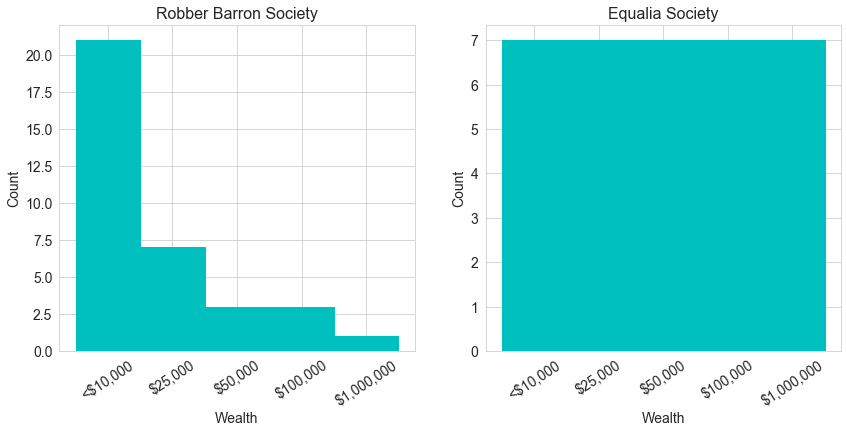

In [130]:
rb = [0, 0, 1, 2, 1, 4, 3, 3, 3, 1, 1, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0]
eq = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4]

plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.title("Robber Barron Society", fontsize=16)
plt.hist(rb, histtype='stepfilled', bins=5, range=(-0.5, 4.5), facecolor='c', edgecolor='c')
plt.xlabel("Wealth", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(range(5), ['<$10,000', '$25,000', '$50,000', '$100,000', '$1,000,000'], fontsize=14, rotation=33)
plt.yticks(fontsize=14)

plt.subplot(122)
plt.title("Equalia Society", fontsize=16)
plt.hist(eq, histtype='stepfilled', bins=5, range=(-0.5, 4.5), facecolor='c', edgecolor='c')
plt.xlabel("Wealth", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(range(5), ['<$10,000', '$25,000', '$50,000', '$100,000', '$1,000,000'], fontsize=14, rotation=33)
plt.yticks(fontsize=14)
plt.show()

The Robber Barron society is clearly very unequal, with a great deal of the wealth concentrated in a few people. In contrast, the Equalia society seems to have an equal number of people in each of the bins. Let's go ahead and use our new Gini impurity function to calculate the impurity of these two societies.

In [131]:
print ("Robber Barron Society: {}".format( gini_impurity(rb) ))
print ("Equalia Society: {}".format( gini_impurity(eq) ))

Robber Barron Society: 0.5844897959183674
Equalia Society: 0.7999999999999999


We can easily see that the Equalia society scores a higher value according to the Gini impurity index. The lower the score is, the more tilted the values are towards one of the classes. The higher the score is, the more equal the number of instances per class. A good way to understand this intuitively is through a visualization. 

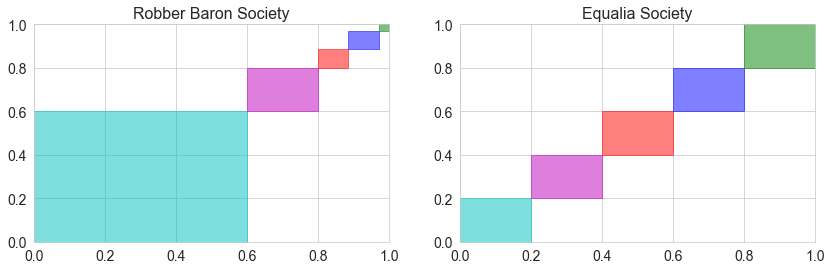

In [153]:
def plot_gini(x):
    """This will create a graphical representation of the gini impurity index.
    
    This will plot boxes where the x and y axes are equal to the proportion of samples
    of that class, and 1 minus the area of all colored boxes is the gini impurity.
    
    Parameters
    ----------
    x : numpy.ndarray, shape=(m,)
        An array of counts over m classes
    
    Returns
    ------
    None
    
    """
    y = np.unique(x,return_counts = True)[1].astype('float')
    #get proportions
    y /= np.sum(y)
    c=0

    for i, yi in enumerate(y):
        #plt.fill_between((x1,x2),y1,y2)
        plt.fill_between((c,c+yi),c,c+yi,color = 'cmrbgy'[i],alpha = 0.5)
        c+=yi #reset new value of c
    
    plt.xlim(0,1)
    plt.ylim(0,1)

plt.figure(figsize = (14,4))
plt.subplot(1,2,1)
plt.title('Robber Baron Society',fontsize = 16)
plot_gini(rb)

plt.subplot(1,2,2)
plt.title('Equalia Society',fontsize = 16)
plot_gini(eq)



In this visualization, the colored squares correspond to the squared probability of each class across the samples. We can see that the poorest class makes up a large chunk of the robber barron society, whereas all of the rectangles are the same size in the Equalia society. The Gini index is not the area of the colored rectangles, but rather 1 minus that area. Ultimately though, whether you are counting the area of the colored squares or the inverse area depends only on if you want to make the optimization problem a maxima or a minima.

Now, how does this relate to decision trees? Simply, we want to minimize the impurity of each one of the leaves in the tree. We want each leaf of the tree to contain samples only coming from a single class, and measure this through the Gini impurity. We actually want each leaf to represent the robber barron society as much as possible because that shows a clearer division of classes than the Equalia society.

A second commonly used criterion for decision tree classifiers is that of entropy. This is the Shannon entropy that is defined in information theory that specifies the amount of information that a certain message can contain. The equation for calculating entropy of a vector with $m$ classes where $y_{i}$ is the number of samples for class $i$ is the following:

\begin{equation}
E = \sum\limits_{i=1}^{m} \left( \frac{ y_{i}}{n} \right) \log \left( \frac{y_{i}}{n} \right)
\end{equation}

This equation looks a lot simpler than the Gini index. Let's go ahead and implement it now.

In [163]:
def shannon_entropy(x):
    """Calculate the Shannon entropy of a set of labels.
    
    This function will calculate the Shannon entropy on a set of samples.
    Note, this is not the 'y' from above. We must first calculate the
    binned counts 'y' from this data. For example:
    
    >>> x = [0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0]
    >>> shannon_entropy(x)
    -0.562335...
    
    
    Parameters
    ----------
    x : numpy.ndarray
        The direct samples (not counts) to calculate the Shannon entropy on.
        
    Returns
    -------
    g : double, range=(0, 1)
        The Shannon entropy of these samples
    """
    y = np.unique(x,return_counts = True)[1].astype('float')
    y /= y.sum()
    shannon = np.sum([yi*np.log(yi) if yi>0 else 0 for yi in y])
    return(shannon)

shannon_entropy(x)

-0.5623351446188083

If we try calculating the entropy on a few values we will immediately realize that these numbers are typically negative, as opposed to the Gini impurity values that were strictly positive. Let's go ahead and plot both the Gini impurity and the Shannon entropy in a binary problem for a range of different imbalances.

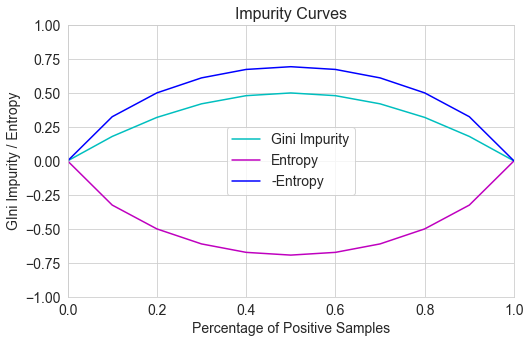

In [185]:
#calculates gini/ent on a list of lists. Map applies the function to each list in the list of lists.
gini = list(map(gini_impurity,[[1 if i >=j else 0 for i in range(10)] for j in range(11)]))
ent = list(map(shannon_entropy, [[1 if i >= j else 0 for i in range(10)] for j in range(11)]))

plt.figure(figsize = (8,5))
plt.title('Impurity Curves',fontsize = 16)
plt.xlabel('Percentage of Positive Samples',fontsize = 14)
plt.ylabel("GIni Impurity / Entropy",fontsize = 14)
plt.xlim(0,1)
plt.ylim(-1,1)
plt.plot(np.arange(0,1.01,0.1),gini,color = 'c',label = 'Gini Impurity')
plt.plot(np.arange(0,1.01,0.1),ent,color = 'm',label = 'Entropy')
plt.plot(np.arange(0,1.01,0.1),[-1*e for e in ent],color = 'b',label = '-Entropy')
plt.legend(fontsize = 14);


Gini impurity and entropy both allow you to create classifiers, as they operate on categories of data. However, one can also create decision tree regressor using the mean squared error (MSE) as the criterion. This corresponds to trying to minimize the variance of the underlying subset of points, or alternatively identifying whether two Gaussians better matches the data than a single Gaussian. Since MSE should be familiar to to most people we will leave the optimization details for later.

# Building a Decision Tree

At this point, we know what a tree looks like, and we know how to measure the impurity of a certain amount of data. Presumably when learning the tree we would like to make splits that decrease the impurity of the labels. Let's take a look at making a simple split.

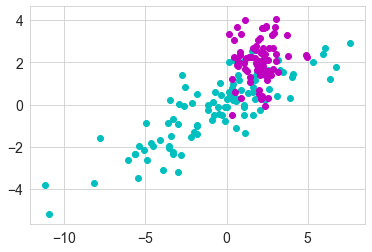

In [196]:
x1 = np.random.randn(100,2).dot([[3,1],[0.3,1]])
x2 = np.random.randn(75,2)+2
X = np.concatenate((x1,x2))
y = np.concatenate((np.zeros(100),np.ones(75)))

plt.scatter(X[y==0,0],X[y==0,1],color = 'c')
plt.scatter(X[y==1,0],X[y==1,1],color = 'm');

Best Split on x-axis (min of red line): point 62 with impurity 0.3265
Best Split on y-axis (min of red line): point 92 with impurity 0.2863


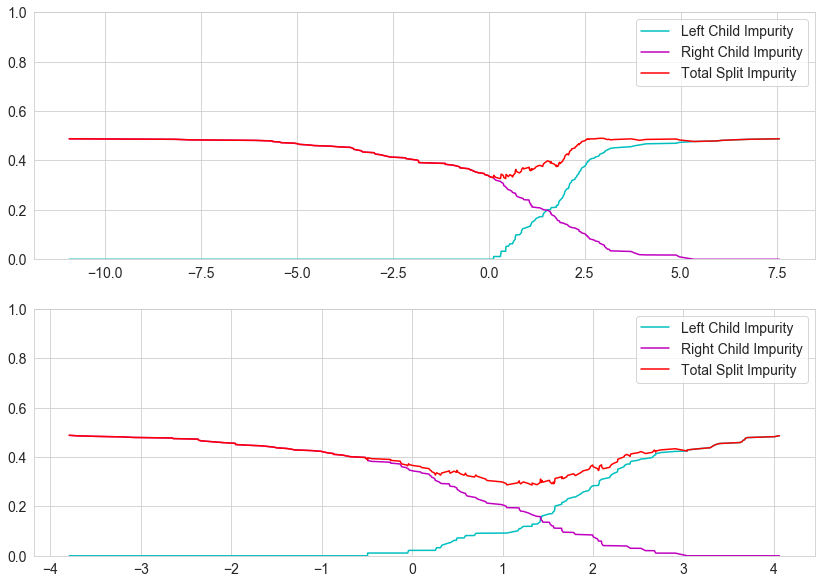

In [248]:
def plot_impurities(X, y, func=gini_impurity):
    """
    Note: we take a weighted average of left/right impurity to get total impurity. This is because the gini calculation
    does not sum over the entire y, it just sums over y on that side of the split. That is, the actualy gini value
    is not dependent on the entire sample size, just the size of the list on which gini is being calculated. 
    So we could get a very high/low Gini value on one side of a split if there are not many elements on that side. As 
    such we want to make sure high/low gini values do account for the fact that the sample might be small.
    
    """
    idxs = X.argsort()  #remember, input X as a single column, not a whole matrix
    left_impurity = numpy.array([func(y[idxs][:i])*i/n for i in range(1, y.shape[0])])
    right_impurity = numpy.array([func(y[idxs][i:])*(n-i)/n for i in range(1, y.shape[0])])
    total_impurity = left_impurity + right_impurity
    
    
    plt.plot(X[idxs][1:], left_impurity, color='c', label="Left Child Impurity")
    plt.plot(X[idxs][1:], right_impurity, color='m', label="Right Child Impurity")
    plt.plot(X[idxs][1:], total_impurity, color='r', label="Total Split Impurity")
    plt.legend(fontsize=14)
    plt.ylim(0, 1)
    return total_impurity.argmin(), total_impurity.min()

plt.figure(figsize=(14, 10))
plt.subplot(211)
idx, min_impurity = plot_impurities(X[:,0], y)
print("Best Split on x-axis (min of red line): point {} with impurity {:4.4}".format(idx, min_impurity))

plt.subplot(212)
idx, min_impurity = plot_impurities(X[:,1], y)
print( "Best Split on y-axis (min of red line): point {} with impurity {:4.4}".format(idx, min_impurity))

Let's now plot stuff.

array([0.32467532, 0.67532468])

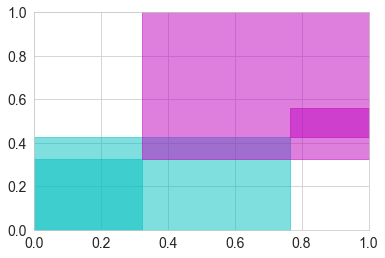

In [289]:
idx = 98
idxs = X[:,0].argsort() #indexes for the first column
x = y[idxs]
#at a specific index, we reorder the ys and calculate the gini for that index
yl = np.unique(x[:idx],return_counts=True)[1].astype('float')
yl /= yl.sum()
yr = np.unique(x[idx:],return_counts=True)[1].astype('float')
yr /= yr.sum()
c=0
wl = float(idx)/len(x)
wr = 1-wl
for i,yi in enumerate(yl):
    plt.fill_between((c,c+yi),c*wl,(c+yi)*wl,color = 'cmrbgy'[i],alpha = 0.5)
    c +=yi

c=0
for i, yi in enumerate(yr):
    plt.fill_between((c,c+yi),c*(wl+wr),(c+yi)*(wl+wr),color = 'cmrbgy'[i],alpha = 0.5)
    c +=yi
plt.xlim(0,1)
plt.ylim(0,1)
yr

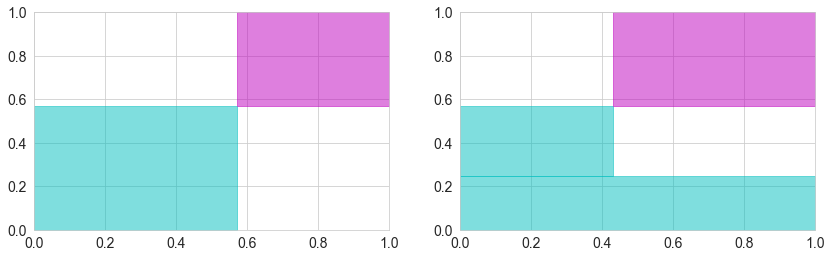

In [267]:
idxs = X[:,0].argsort()

def plot_split_gini(x, idx):
    """This helper function will help show the change in gini impurity at a split.
    
    This function will take in a split and plot both gini visualizations as before, weighted
    by the number of samples on either side of the split. If this is a good split, then the
    amount of white space should decrease in the right hand plot, otherwise it indicates that
    the split is not very good.
    
    Parameters
    ----------
    x : numpy.ndarray, shape=(m,)
        An array of the counts over m classes
    
    idx : int
        The index to split on. The first idx samples are assigned to the left split, the
        remainder are assigned to the right split.
    """
    #at a specific index, we reorder the ys and calculate the gini for that index
    yl = numpy.unique(x[:idx], return_counts=True)[1].astype('float')
    yl /= yl.sum()
    yr = numpy.unique(x[idx:], return_counts=True)[1].astype('float')
    yr /= yr.sum()
    c = 0
    
    wl = float(idx) / len(x)
    wr = 1 - wl
    
    #plot the impurity for the two classes in the left side
    for i, yi in enumerate(yl):
        plt.fill_between((c, c+yi), c*wl, (c+yi)*wl, color='cmrbgy'[i], alpha=0.5)
        c += yi
    
    c = 0
    #plot the impurity for the two classes on the right side
    for i, yi in enumerate(yr):
        plt.fill_between((c, c+yi), c*wr+wl, (c+yi)*wr+wl, color='cmrbgy'[i], alpha=0.5)
        c += yi
    
    plt.xlim(0, 1)
    plt.ylim(0, 1)

plt.figure(figsize=(14, 4))
plt.subplot(121)

#in this function, we calculate the gini across the entirety of y all at once. So there is 
#really only 'one' blue square and 'one' purple square
plot_gini(y)

plt.subplot(122)

#in this funciton, we calculate the gini in two samples based on our split. As such we will
#actually end up with 'two' blue squares and 'two' purple squares that have some overlap.
#What we want to see is that the gini here is less than the gini above. If we have
#properly sorted our elements into separate buckets then the separate ginis should combine
#to be less than the combined gini.
plot_split_gini(y[idxs], 43)

Since we have normalized the rectangles by the number of points in the split, it is fair to simply look at the colored area versus the uncolored area of the two. This way we can visualize the 'gain' caused by the split in terms of a gain in colored area versus uncolored area. Let's find the worst split we could make and visualize that.

Worst split on x-axis: point 151 with impurity 0.4898
(174,)


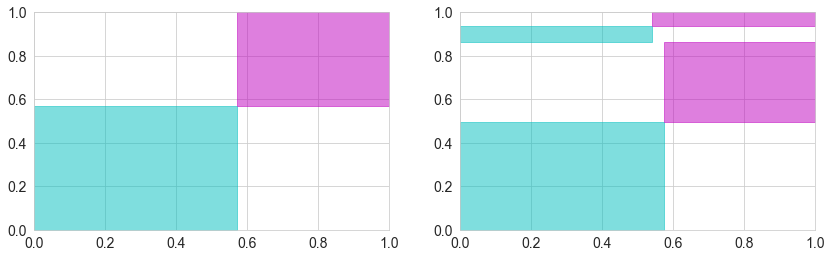

In [322]:
idxs = X[:,0].argsort()
n = float(y.shape[0])

left_impurity = np.array([gini_impurity(y[idxs][:i])*i/n for i in range(1, y.shape[0])])
right_impurity = np.array([gini_impurity(y[idxs][i:])*(n-i)/n for i in range(1, y.shape[0])])
total_impurity = left_impurity + right_impurity

print("Worst split on x-axis: point {} with impurity {:4.4}".format(total_impurity.argmax(), total_impurity.max()))

plt.figure(figsize=(14, 4))
plt.subplot(121)
plot_gini(y)

plt.subplot(122)
plot_split_gini(y[idxs], total_impurity.argmax()) #argmin would be the best split
print(total_impurity.shape)

So to distill all of this down to a single function, we can do the following, which will take in a feature and the labels and identify the best split. 

175.0


In [378]:
new_x = X[0:30,0]
new_y = y[0:30]
idxs = new_x.argsort()
n = new_x.shape[0]
left_impurity = numpy.array([gini_impurity(new_y[idxs][:i])*i/n for i in range(1, new_y.shape[0])])
right_impurity = numpy.array([gini_impurity(new_y[idxs][i:])*(n-i)/n for i in range(1, new_y.shape[0])])
total_impurity = left_impurity + right_impurity

min_idx = total_impurity.argmin()
threshold = (new_x[idxs][min_idx] + new_x[idxs][min_idx+1]) / 2. 
new_x[idxs]

array([-5.44140401e+00, -4.96732280e+00, -4.68602337e+00, -3.92460778e+00,
       -2.98218650e+00, -2.94328142e+00, -2.55909309e+00, -2.16512562e+00,
       -1.99939839e+00, -1.82603052e+00, -1.13192953e+00, -1.12802976e+00,
       -7.45060716e-01, -4.11744690e-01, -3.63070097e-01, -1.16634033e-01,
       -5.44062054e-03,  2.20055527e-02,  1.54684483e-01,  3.73101144e-01,
        4.54951320e-01,  6.01595170e-01,  7.13566190e-01,  7.34847737e-01,
        1.73859981e+00,  2.04466805e+00,  2.35217414e+00,  2.60813725e+00,
        3.28692650e+00,  5.94286906e+00])

In [332]:
def find_best_split(X, y):
    """This function will find the best split and return the impurity and index.
    
    This function will take in a vector X and identify the best split according to that
    vector, evaluated on how well it partitions y into pure groups. It will evaluate the
    gini impurity at each possible split and return the best split.
    
    Parameters
    ----------
    X : numpy.ndarray, shape=(n,)
        The data used to order y by when finding the best partition. This is typically
        a single column from the data the tree is being learned over.
    
    y : numpy.ndarray, shape=(n,)
        The labels for the data.
    
    Returns
    -------
    min_total_impurity : double
        The total impurity across both sides of the split for the best split
    
    threshold : double
        The threshold at which one would split.
        
    """
    
    idxs = X.argsort()
    n = X.shape[0]
    left_impurity = numpy.array([gini_impurity(y[idxs][:i])*i/n for i in range(1, y.shape[0])])
    right_impurity = numpy.array([gini_impurity(y[idxs][i:])*(n-i)/n for i in range(1, y.shape[0])])
    total_impurity = left_impurity + right_impurity
    
    min_idx = total_impurity.argmin() #find index with least impurity (most purity)
    threshold = (X[idxs][min_idx] + X[idxs][min_idx+1]) / 2. #take actual value of X that has the index = to leas impurity
                                                            #and then look for the next value up. The middle of that
                                                            #is where we will split the column.
    return total_impurity.min(), threshold

The next thing we need to do is to scan over all of the features and return the feature that has the best split.

In [333]:
def find_best_feature(X, y):
    """This helper function will identify the best split across all features.
    
    When deciding where to make the best split, all features must be considered. This function
    will call `find_best_split` on each feature, identify the feature yielding the best split,
    and return that.
    
    Parameters
    ----------
    X : numpy.ndarray, shape=(n, d)
        The dataset that this section of the tree is being learned on.
    
    y : numpy.ndarray, shape=(n,)
        The corresponding labels for the data
    
    Returns
    -------
    best_feature : int
        The index of the feature the best split was found in.
    
    best_threshold : double
        The threshold identified for that feature, where samples that are less than this
        value go to the left in the tree, and samples that are greater than or equal to
        go to the right in the tree.
    
    best_impurity : double
        The total impurity for this split, equal to the summation of the impurities on
        either side of the split.
    """
    
    best_impurity, best_split, best_feature, best_threshold = 1, None, None, None
    for feature in range(X.shape[1]):
        impurity, threshold = find_best_split(X[:,feature], y)
        if impurity < best_impurity:
            best_impurity, best_threshold, best_feature, = impurity, threshold, feature
    
    return best_feature, best_threshold, best_impurity

In [374]:
counts = numpy.unique(y, return_counts=True)[1]
value = counts.argmax()
find_best_split(X[0:30,1], y[0:30])

(0.0, -3.2910192328916965)

In [373]:
new_x = X[0:75,0:2]
idxs = new_x.argsort()
n = new_x.shape[0]
left_impurity = numpy.array([gini_impurity(y[idxs][:i])*i/n for i in range(1, y.shape[0])])
right_impurity = numpy.array([gini_impurity(y[idxs][i:])*(n-i)/n for i in range(1, y.shape[0])])
total_impurity = left_impurity + right_impurity

min_idx = total_impurity.argmin() #find index with least impurity (most purity)
#threshold = (X[idxs][min_idx] + X[idxs][min_idx+1]) / 2. #take actual value of X that has the index = to leas impurity
                                                        #and then look for the next value up. The middle of that
                                                        #is where we will split the column.
min_idx


173

In [370]:

counts = numpy.unique(y[0:30], return_counts=True)[1]
value = counts.argmax()
    
feature, threshold, impurity = find_best_feature(X[0:30,:], y[0:30])

li = X[:,feature] < threshold  #gather part of X that is less than threho
ri = X[:,feature] >= threshold
len(y[0:30])

30

In [334]:
def recursively_split(X, y):
    """This is the main function to learn a tree, through recursive splits.
    
    A tree is a recursive structure, in that each inner node within the tree is itself
    a tree. Since only portions of the dataset are sent either left or right at each
    split, the decision tree building task itself is recursive over these partitions
    of the dataset. For example, if I am building a tree over 100 samples originally and
    send 63 of them to the left child, I then repeat the same opertions over only those 63
    samples to and partition the dataset again, accordingly. The tree is thus built in a
    depth first manner.
    
    Parameters
    ----------
    X : numpy.ndarray, shape=(n, d)
        The dataset that this section of the tree is being learned on
    
    y : numpy.ndarray, shape=(n,)
        The corresponding labels for the data.
    
    Returns
    -------
    tree : tuple of tuples
        Each tuple corresponds to (feature, threshold, value) for a particular node in the tree.
        If the node is a leaf node, then feature and threshold are set to None, and value is the
        value that is predicted at this leaf.
    """
    
    
    if len(y) == 1:
        return ((None, None, y[0]),)

    counts = numpy.unique(y, return_counts=True)[1]
    value = counts.argmax()
    
    feature, threshold, impurity = find_best_feature(X, y)
    
    li = X[:,feature] < threshold  #gather part of X that is less than threho
    ri = X[:,feature] >= threshold
    
    if li.sum() == 0 or ri.sum() == 0: #if either side of the branch is empty then we are done
        return ((None, None, value),)
    
    return ((feature, threshold, value),) + \
            recursively_split(X[li], y[li]) + \
            recursively_split(X[ri], y[ri]) 

In [336]:
tree = recursively_split(X, y)
print(tree)

((1, 1.3053114953914973, 0), (0, 1.8713643829159352, 0), (1, 1.1934347225496305, 0), (0, 0.2542641139042656, 0), (0, -11.044877345806764, 0), (None, None, 0.0), (0, -9.545270656490295, 0), (None, None, 0.0), (0, -7.969121672120686, 0), (None, None, 0.0), (0, -6.9209858866738525, 0), (None, None, 0.0), (0, -5.855748409512393, 0), (None, None, 0.0), (0, -5.6361248701770155, 0), (None, None, 0.0), (0, -5.535703009116776, 0), (None, None, 0.0), (0, -5.425677115418507, 0), (None, None, 0.0), (0, -5.239015583614467, 0), (None, None, 0.0), (0, -5.017701870179689, 0), (None, None, 0.0), (0, -4.951047964742591, 0), (None, None, 0.0), (0, -4.810398248251982, 0), (None, None, 0.0), (0, -4.61802169771711, 0), (None, None, 0.0), (0, -4.33315406353167, 0), (None, None, 0.0), (0, -4.02044793724467, 0), (None, None, 0.0), (0, -3.7626445690171764, 0), (None, None, 0.0), (0, -3.574583071724928, 0), (None, None, 0.0), (0, -3.536626052691484, 0), (None, None, 0.0), (0, -3.518552935769818, 0), (None, None,

# Let's Code a Decision Tree Now!

We now have all the tools that we need at our disposal in order to create a decision tree estimator. Let's create it using the same API as sklearn, such that there is a `fit` method that takes in the data the tree is built over, and a `predict` method that uses the learned tree to make predictions as to the labels on new data. There should also be a `score` function that takes in both X and y and evaluates the models performance in X when compared to a true labeling of y.

In [396]:
class DecisionTree(object):
    """This is the decision tree object that we are going to build together.
    
    This estimator will ultimately have two main methods, `fit` and `predict`,
    where `fit` will build a decision tree based on labeled training data that
    is passed in, and `predict` will assign labels to unlabeled samples in
    the future.
    """
    
    def __init__(self):
        pass
    
    def _recursively_split(self, X, y):
        """This is the main function to learn a tree, through recursive splits.

        A tree is a recursive structure, in that each inner node within the tree is itself
        a tree. Since only portions of the dataset are sent either left or right at each
        split, the decision tree building task itself is recursive over these partitions
        of the dataset. For example, if I am building a tree over 100 samples originally and
        send 63 of them to the left child, I then repeat the same opertions over only those 63
        samples to and partition the dataset again, accordingly. The tree is thus built in a
        depth first manner. This differs from the previous method in tht there is a global
        counter to assign indexes to each node in a depth first manner, to more easily
        enable predictions.

        Parameters
        ----------
        X : numpy.ndarray, shape=(n, d)
            The dataset that this section of the tree is being learned on

        y : numpy.ndarray, shape=(n,)
            The corresponding labels for the data.

        Returns
        -------
        tree : tuple of tuples
            Each tuple corresponds to (feature, threshold, value, left_child, right_child), 
            for a particular node in the tree. If the node is a leaf node, then feature and 
            threshold are set to None, and value is the value that is predicted at this leaf.
        """
        
        self.idx += 1
        if len(y) == 1:
            return ((None, None, y[0], None, None),)
        
        feature, threshold, impurity = find_best_feature(X, y)
        value = numpy.unique(y, return_counts=True)[1].argmax()

        li = X[:,feature] < threshold
        ri = X[:,feature] >= threshold
        
        if li.sum() == 0 or ri.sum() == 0:
            return ((None, None, value, None, None),)
        
        left_child = self.idx + 1
        left = self._recursively_split(X[li], y[li])
        
        right_child = self.idx + 1
        right = self._recursively_split(X[ri], y[ri])
        
        return ((feature, threshold, value, left_child, right_child),) + left + right
    
    def fit(self, X, y):
        """This is the main fitting function for the tree.
        
        This function serves as a wrappper for the recursive splitting function,
        making it easier for the user to use.
        
        Parameters
        ----------
        X : numpy.ndarray, shape=(n, d)
            The dataset that this section of the tree is being learned on

        y : numpy.ndarray, shape=(n,)
            The corresponding labels for the data.

        Returns
        -------
        self : DecisionTree
            A fit DecisionTree object.
        """
        
        self.idx = -1
        self.tree = self._recursively_split(X, y)
        return self

    def _predict_sample(self, x):
        """Use the tree to predict a single sample.

        This function will take in a single sample and predict the
        label for it. For many samples, use `predict`.

        Parameters
        ----------
        x : numpy.ndarray, shape=(d,)
            A single sample with one entry per dimension.

        Returns
        -------
        y : int
            The integer label that the tree predicts for this sample.
        """

        i = 0
        while True:
            feature, threshold, value, left_child, right_child = self.tree[i]
            
            if left_child is None or right_child is None:
                return value
            elif x[feature] < threshold:
                i = left_child
            else:
                i = right_child

    def predict(self, X):
        """This function will predict the labels of each sample given the learned model.
        
        This function takes in a matrix of data and will use the tree to predict the label
        of each one of the samples. This is done through successive calls to the 
        `_predict_sample` method that predicts only for a single sample.
        
        Parameters
        ----------
        X : numpy.ndarray, shape=(n, d)
            A matrix of n samples with d dimensions, with the same dimensionality
            as the original training data.

        Returns
        -------
        y : numpy.ndarray, shape=(n,)
            The integer labels that the tree predicts for the samples.
        """
        
        return numpy.array(list(map(self._predict_sample, X)))
    
    def score(self, X, y):
        """This function will score the model given data and correct labels.
        
        For the classification task, this will return the average accuracy of the model
        over all the samples. For regression tasks, this could return several things
        including the MSE, R^2, or MAE of the predictions.

        Parameters
        ----------
        X : numpy.ndarray, shape=(n, d)
            A matrix of n samples with d dimensions, with the same dimensionality
            as the original training data.
        
        y : numpy.ndarray, shape=(n,)
            The corresponding labels for the data.

        Returns
        -------
        score : double
            The average accuracy of the model on the given data.
        """
        
        return (self.predict(X) == y).mean()

While you are building your decision tree model, here are some code samples that should help you determine if you are on the right path.

## Binary Classification

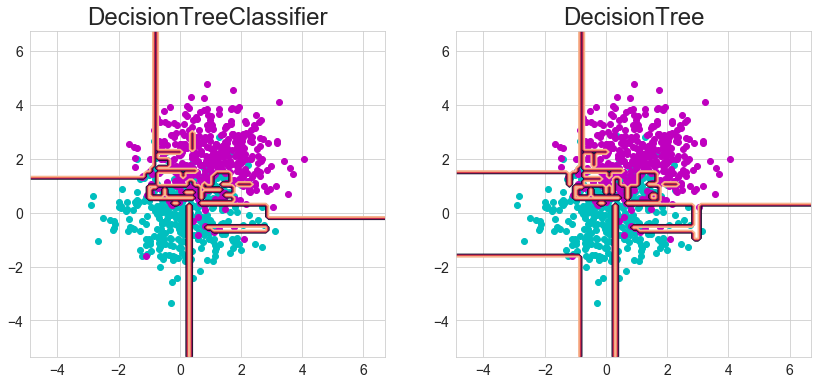

In [400]:
from sklearn.datasets import make_blobs

X, y = make_blobs(1000, 2, centers=[[0, 0], [1, 2]], cluster_std=1, shuffle=True)
X_train, X_test, y_train, y_test = X[:750], X[750:], y[:750], y[750:]

plt.figure(figsize=(14, 6))
plot_contours(X_train, y_train, DecisionTreeClassifier(), DecisionTree())


Aside from graphs, let's take a look at the performance of the model in terms of training and test set accuracy. An unregularized decision tree like we have here should perform perfectly on the test set, so if you aren't seeing that with your tree there is likely an error.

In [401]:
sklearn_tree = DecisionTreeClassifier().fit(X_train, y_train)
our_tree = DecisionTree().fit(X_train, y_train)

print("sklearn training set score: ", sklearn_tree.score(X_train, y_train))
print("sklearn test set score: ", sklearn_tree.score(X_test, y_test))
print()
print("our tree training set score: ", our_tree.score(X_train, y_train))
print("our tree test set score: ", our_tree.score(X_test, y_test))

sklearn training set score:  1.0
sklearn test set score:  0.836

our tree training set score:  1.0
our tree test set score:  0.84


Accuracy is not our only metric for performance. Decision trees range in their implementations, from terribly slow to extremely fast. sklearn is one of the faster implementations because it is done in cython. Let's see how well our tree stands up to their implementation!

In [402]:
print("sklearn training time")
%timeit DecisionTreeClassifier().fit(X_train, y_train)
print()
print("our tree training time")
%timeit DecisionTree().fit(X_train, y_train)

sklearn training time
1.19 ms ± 22.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

our tree training time
3.06 s ± 114 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Now that we've looked at training time, let's look at prediction time. Both are important to consider in a model, but typically fitting is the more problematic of the two.

In [403]:
print("sklearn prediction time")
%timeit sklearn_tree.predict(X_train)
print()
print("our tree prediction time")
%timeit our_tree.predict(X_train)

sklearn prediction time
117 µs ± 2.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

our tree prediction time
7.54 ms ± 1.26 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Multiclass Prediction

Let's move away from a simple binary task on two dimensional data to a larger example, with four classes and 10 dimensions. If your example can work here, then the model is likely correct and can work on any example!

We will avoid plotting this example since most people can't see in ten dimensions.

In [405]:
X, y = make_blobs(1000, 10, cluster_std=2, shuffle=True)
X_train, X_test, y_train, y_test = X[:750], X[750:], y[:750], y[750:]

In [406]:
sklearn_tree = DecisionTreeClassifier().fit(X_train, y_train)
our_tree = DecisionTree().fit(X_train, y_train)

print("sklearn training set score: ", sklearn_tree.score(X_train, y_train))
print("sklearn test set score: ", sklearn_tree.score(X_test, y_test))
print()
print("our tree training set score: ", our_tree.score(X_train, y_train))
print("our tree test set score: ", our_tree.score(X_test, y_test))

sklearn training set score:  1.0
sklearn test set score:  1.0

our tree training set score:  1.0
our tree test set score:  1.0


In [407]:
print("sklearn training time")
%timeit DecisionTreeClassifier().fit(X_train, y_train)
print()
print("our tree training time")
%timeit DecisionTree().fit(X_train, y_train)

sklearn training time
1.32 ms ± 25 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

our tree training time
1min 13s ± 3.52 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [408]:
print("sklearn prediction time")
%timeit sklearn_tree.predict(X_train)
print()
print("our tree prediction time")
%timeit our_tree.predict(X_train)

sklearn prediction time
101 µs ± 1.79 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

our tree prediction time
32.8 ms ± 2.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Success!

If you have made it to this point, then you have successfully coded your first decision tree from scratch. This tree is likely slower then the decision trees that are implemented in sklearn, but that's okay! You have likely also noticed that the training set score is always equal to 1 in a decision tree but that the test set score is typically far lower. This is a sign of <b>overfitting</b>, which is a sign that the model is fitting to the excentricities of the training set instead of just the general trends. A common way that overfitting is overcome in tree based models is to train an ensemble of trees called a "random forest" instead of a single tree.

# Random Forests

Random forests are an ensemble model that use many decision trees in order to make a prediction. They typically grow the trees independently (and possibly in parallel) and then make predictions by letting each tree vote on what it thinks that the appropriate class is. Estimates of certainty can be derived from the aggregation of these votes. In the case of regression trees, the predictions are typically averaged together for the final prediction. However, one could also take the standard deviation to get a measurement of uncertainty as well as value.

If one were to grow many trees independently on the same dataset, they would get the same tree over and over again. This is because the tree growing procedure is deterministic and so the same tree is produced on the same dataset. The only time this may not be the case is if there are multiple equally good splits at a certain point in the dataset and the features are chosen randomly to be considered. In this situation, the order at which these equivalent splits are sampled might change between different trees. 

For a random forest to fully utilizee an ensemble of decision trees, one must build the trees on different datasets. Typically one would do this through two methods, bootstrapping[<a href="https://en.wikipedia.org/wiki/Bootstrapping_(statistics)">1</a>], where a new dataset is produced by resampling the dataset with replacement, and only using a subset of the features. This means that each tree sees both different samples and a different set of features. This causes the ensemble to be made up of very different trees.

The implementation of a random forest should be fairly simple. Bootstrapping the samples ends up being a fairly simple procedure for a toy example. Considering only a subset of features is a bit trickier, because it is not that the full tree is built on only a subset of features, it is that only a subset of features are considered at each split. This means that the full tree can include splits on all variables, but that when trying to identify the best split for a node, the number of features is limited. To take this into account we will need to modify the code slightly to take in a `max_features` parameter to specify the maximum number of features to consider. First, we should change the `find_best_feature` function.

In [404]:
def find_best_feature(X, y, max_features=None):
    """This helper function will identify the best split across all features.
    
    When deciding where to make the best split, all features must be considered. This function
    will call `find_best_split` on each feature, identify the feature yielding the best split,
    and return that.
    
    Parameters
    ----------
    X : numpy.ndarray, shape=(n, d)
        The dataset that this section of the tree is being learned on.
    
    y : numpy.ndarray, shape=(n,)
        The corresponding labels for the data
        
    max_features : int or None
        The maximum number of features to consider in a split. If set to None, then use all features.
    
    Returns
    -------
    best_feature : int
        The index of the feature the best split was found in.
    
    best_threshold : double
        The threshold identified for that feature, where samples that are less than this
        value go to the left in the tree, and samples that are greater than or equal to
        go to the right in the tree.
    
    best_impurity : double
        The total impurity for this split, equal to the summation of the impurities on
        either side of the split.
    """
    
    max_features = max_features or X.shape[1]
    features = numpy.random.choice(X.shape[1], size=max_features)
    best_impurity, best_threshold, best_feature = 1, None, None
    
    for feature in features:
        impurity, threshold = find_best_split(X[:,feature], y)
        if impurity < best_impurity:
            best_impurity, best_threshold, best_feature = impurity, threshold, feature
    
    return best_feature, best_threshold, best_impurity

Now we need to rewrite the decision tree code a litle bit to take into account the maximum feature setting. For speed purposes, let's use the sklearn decision tree class, since it is a few orders of magnitude faster while still producing the same results. Ultimately, the forest is just a way of creating appropriate datasets to fit trees on and then aggregating the prediction results from those trees, so it doesn't matter what we are doing internally.

In [38]:
class RandomForest():
    def __init__(self, n_estimators=10, max_features=None):
        self.n_estimators = n_estimators
        self.max_features = max_features
    
    def fit(self, X, y):
        """This is the main fitting function for the ensemble.
        
        This involves training an ensemble of trees to build a better
        model than a single tree could provide. Each tree is built on
        a bootstrapped sample of the dataset, meaning that a new dataset
        is built on a resampled dataset.
        
        Parameters
        ----------
        X : numpy.ndarray, shape=(n, d)
            The dataset that this section of the tree is being learned on

        y : numpy.ndarray, shape=(n,)
            The corresponding labels for the data.

        Returns
        -------
        self : DecisionTree
            A fit DecisionTree object.
        """
        
        n, d = X.shape
        if self.max_features is None:
            max_features = int(numpy.sqrt(d))
        else:
            max_features = self.max_features
    
        self.trees = []
        for i in range(self.n_estimators):
            bootstrap_idx = numpy.random.randint(n, size=n)
            X_bootstrap = X[bootstrap_idx].copy()
            y_bootstrap = y[bootstrap_idx].copy()
            
            tree = DecisionTreeClassifier(max_features=max_features).fit(X_bootstrap, y_bootstrap)
            self.trees.append(tree)
        
        return self
    
    def predict(self, X):
        """This function will predict the labels of each sample given the learned model.
        
        This function takes in a matrix of data and will use the ensemble of trees to 
        predict the label of each one of the samples. This is done by having each tree
        vote on the label and then returning the consensus call amongst all of the
        trees.
        
        Parameters
        ----------
        X : numpy.ndarray, shape=(n, d)
            A matrix of n samples with d dimensions, with the same dimensionality
            as the original training data.

        Returns
        -------
        y : numpy.ndarray, shape=(n,)
            The integer labels that the ensemble predicts for the samples.
        """
        
        votes = []
        
        for tree in self.trees:
            vote = tree.predict(X)
            votes.append(vote)
        
        votes = numpy.array(votes)
        
        y_preds = []
        for i in range(X.shape[0]):
            keys, counts = numpy.unique(votes[:,i], return_counts=True)
            y_pred = keys[counts.argmax()]
            y_preds.append(y_pred)
        
        return y_preds
    
    def score(self, X, y):
        """This function will score the model given data and correct labels.
        
        For the classification task, this will return the average accuracy of the model
        over all the samples. For regression tasks, this could return several things
        including the MSE, R^2, or MAE of the predictions.

        Parameters
        ----------
        X : numpy.ndarray, shape=(n, d)
            A matrix of n samples with d dimensions, with the same dimensionality
            as the original training data.
        
        y : numpy.ndarray, shape=(n,)
            The corresponding labels for the data.

        Returns
        -------
        score : double
            The average accuracy of the model on the given data.
        """
        
        return numpy.mean(self.predict(X) == y)

To make a random forest regressor, we need only replace the classification trees with regression trees, and then aggregate the results using the mean. We could alternatively aggregate the predictions using the median, but since in the optimization step we are optimizing for the mean, we may not be producing the optimal trees for the median. Essentially, if you want to aggregate the results using the mean, you should optimize for the mean squared error (mse), and if you want to aggregate the results using the median, you should optimize for the mean absolute error (mae).

Now let's take a look at the timing results, like we did above for individual trees.

In [39]:
sklearn_forest = RandomForestClassifier().fit(X_train, y_train)
our_forest = RandomForest().fit(X_train, y_train)

print("sklearn training set score: ", sklearn_forest.score(X_train, y_train))
print("sklearn test set score: \n", sklearn_forest.score(X_test, y_test))
print()
print("our forest training set score: ", our_forest.score(X_train, y_train))
print("our forest test set score: ", our_forest.score(X_test, y_test))

('sklearn training set score: ', 1.0)
('sklearn test set score: \n', 1.0)
()
('our forest training set score: ', 1.0)
('our forest test set score: ', 1.0)


In [40]:
print("sklearn training time")
%timeit RandomForestClassifier().fit(X_train, y_train)
print()
print("our forest training time")
%timeit RandomForest().fit(X_train, y_train)

sklearn training time
1 loop, best of 3: 149 ms per loop
()
our forest training time
10 loops, best of 3: 45.9 ms per loop


In [41]:
print("sklearn prediction time")
%timeit sklearn_forest.predict(X_train)
print()
print("our forest prediction time")
%timeit our_forest.predict(X_train)

sklearn prediction time
10 loops, best of 3: 37.3 ms per loop
()
our forest prediction time
10 loops, best of 3: 55.6 ms per loop
